# Final Project: Bias in datasets

Datasets are playing a more and more important role in object recognition projects. Currently, there are numerous datasets available and each of these datasets has their main focus. However, object recognition researchers merely focus on the result of their methods based on one dataset, which makes it hard to decide the realworld performance of the method. Furthermore, considering the bias of datasets, focusing on the result based on one dataset will prevent the method from generally applicable. 

In this PROJECT, we focus on the bias of some commonly used object recognition datasets, *COCO* and *IAPR-TC-12*. We train a model using same amount of inputs from both datasets. If these two datasets have no bias, the model will have a hard time distinguishing samples from one dataset to an- other. We hope our research can make researchers realize that doing testing on merely one dataset can reach bias results and researchers should calculate their results based on more datasets.

## 1. Data Exploration and Setup

### 1.1 Download the dataset

In [6]:
# Download the dataset.
# IAPR-TC-12
# Information about this dataset in the following URL:
# https://www.imageclef.org/photodata
!wget -nc http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz

# COCO
# Information about this dataset in the following URL:
# https://cocodataset.org/#home
!wget -nc http://images.cocodataset.org/zips/val2017.zip!wget http://images.cocodataset.org/zips/val2017.zip
!tar xf iaprtc12.tgz
!unzip -q val2017.zip

--2020-12-03 06:11:56--  http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz
Resolving www-i6.informatik.rwth-aachen.de (www-i6.informatik.rwth-aachen.de)... 137.226.36.140
Connecting to www-i6.informatik.rwth-aachen.de (www-i6.informatik.rwth-aachen.de)|137.226.36.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1764963259 (1.6G) [application/x-tar]
Saving to: ‘iaprtc12.tgz’

iaprtc12.tgz        100%[===================>]   1.64G  61.6MB/s    in 29s     

2020-12-03 06:12:25 (57.5 MB/s) - ‘iaprtc12.tgz’ saved [1764963259/1764963259]

--2020-12-03 06:12:25--  http://images.cocodataset.org/zips/val2017.zip!wget
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.129.195
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.129.195|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-12-03 06:12:25 ERROR 404: Not Found.

--2020-12-03 06:12:25--  http://images.cocodataset.org/zips/val20

In [1]:
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip

--2020-12-03 06:08:10--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.141.132
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.141.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  35.9MB/s    in 7.3s    

2020-12-03 06:08:17 (33.2 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



### 1.2 Split the dataset

Setting stardards for splitting

In [5]:
import json, os

# Setting up the current dataset path
# dataset_path = '/content/drive/MyDrive/2020Fall Vision & Language/Project/new_dataset'
dataset_path = '/content/'
iaprtc12_path = os.path.join(dataset_path, 'iaprtc12', 'images')
coco_path = os.path.join(dataset_path, 'val2017')
# Could add more data resources here
datasets_path = [iaprtc12_path, coco_path]
print('Current datasets paths: ', datasets_path)

# Setting up dataset path for training and testing after spliting
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')
print('Training dataset path after spliting: ' + train_path)
print('Testing dataset path after spliting: ' + test_path)

# Training and testing spliting ratio
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1




Current datasets paths:  ['/content/iaprtc12/images', '/content/val2017']
Training dataset path after spliting: /content/train
Testing dataset path after spliting: /content/test


Split the image data

In [7]:
# Avoid name conflict
def mkdir(path):
  cur = 0
  while os.path.isfile(path):
    cur += 1
  if cur != 0:
    path += str(cur)
  os.mkdir(path)
  return path

In [10]:
import random

def split_images(datasets_path, out_dir, train_ratio = 0.7, val_ratio = 0.2):
  train_data = {}
  test_data = {}
  val_data = {}
  meta = []
  train_path = os.path.join(out_dir, 'train')
  test_path = os.path.join(out_dir, 'test') 
  val_path = os.path.join(out_dir, 'val')
  train_path = mkdir(train_path)
  test_path = mkdir(test_path) 
  val_path = mkdir(val_path)
  minimal_len = -1
  for label, path in enumerate(datasets_path):
    curr_meta = []
    for root, dirs, files in os.walk(path):
      for file_name in files:
        file_path = os.path.join(root, file_name)
        if file_name.endswith('.jpg'):
          curr_meta.append(file_path)
    random.shuffle(curr_meta)
    meta.append(curr_meta)
    if minimal_len == -1 or len(curr_meta) < minimal_len:
      minimal_len = len(curr_meta)
  train_num = int(minimal_len * train_ratio)
  val_num = int(minimal_len * val_ratio) + train_num
  ranges = [(0, train_num), (train_num, val_num), (val_num, minimal_len)]
  for label, path in enumerate(datasets_path):
    for pos, l in enumerate(ranges):
      for file_path in meta[label][l[0]:l[1]]:
        file_name = os.path.split(file_path)[1]
        if pos == 0:
          train_data[file_name] = label
          os.system(f'cp {file_path} {train_path}')
        elif pos == 1:
          val_data[file_name] = label
          os.system(f'cp {file_path} {val_path}')
        else:
          test_data[file_name] = label
          os.system(f'cp {file_path} {test_path}')
  return train_data, val_data, test_data

In [11]:
# Dump label information into json files
def mkjson(data, out_dir, file_name):
  file_path = os.path.join(out_dir, file_name)
  with open(file_path, 'w') as outfile:
    json.dump(data, outfile)

In [52]:
# split(datasets_path, dataset_path)
dataset_path = '/content/'
train_data, val_data, test_data = split_images(datasets_path, dataset_path)
mkjson(train_data, dataset_path, 'train.txt')
mkjson(test_data, dataset_path, 'test.txt')
mkjson(val_data, dataset_path, 'val.txt')

Split the text data (linking text data to image data)

In [14]:
from pycocotools.coco import COCO
from bs4 import BeautifulSoup

In [21]:
COCO_texts = []
dataDir='/content'
dataType='val2017'
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)
annIds = coco_caps.getAnnIds()
anns = coco_caps.loadAnns(annIds)
for ann in anns:
  COCO_texts.append(ann['caption'])
print(len(COCO_texts))
random.shuffle(COCO_texts)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
25014


In [26]:
IA_texts = []
path = '/content/iaprtc12/annotations_complete_eng'
for root, dirs, files in os.walk(path):
  for file_name in files:
    file_path = os.path.join(root, file_name)
    if file_name.endswith('.eng'):
      try:
        string = open(file_path, 'r').read()
        soup = BeautifulSoup(string)
        text = soup.description.string.split(";")[0]
        if len(text) != 0:
          IA_texts.append(text)
      except:
        pass
random.shuffle(IA_texts)
print(len(IA_texts))

17588


In [56]:
data_size = len(train_data) + len(val_data) + len(test_data)
data_size /= 2
print(data_size)

5000.0


In [64]:
def linking(COCO_texts, IA_texts, img_train, img_val, img_test):
  texts_dict = {}
  train_data = {}
  test_data = {}
  val_data = {}
  COCO_index = 0
  IA_index = 0
  for pos, dataset in enumerate([img_train, img_val, img_test]):
    for key in dataset:
      id = len(texts_dict)
      if dataset[key] == 0:
        texts_dict[id] = IA_texts[IA_index]
        IA_index += 1
      else:
        texts_dict[id] = COCO_texts[COCO_index]
        COCO_index += 1
      if pos == 0:
        train_data[key] = id
      elif pos == 1:
        val_data[key] = id
      elif pos == 2:
        test_data[key] = id
  return texts_dict, train_data, val_data, test_data

In [65]:
texts_dict, train_texts, val_texts, test_texts = linking(COCO_texts, IA_texts, train_data, val_data, test_data)

In [45]:
def split_texts(COCO_texts, IA_texts, datasize, train_ratio = 0.7, val_ratio = 0.2):
  train_data = {}
  test_data = {}
  val_data = {}
  texts_dict = {}
  train_num = int(datasize * train_ratio)
  val_num = int(datasize * val_ratio) + train_num
  ranges = [(0, train_num), (train_num, val_num), (val_num, datasize)]
  for label, dataset in enumerate([IA_texts, COCO_texts]):
    for pos, l in enumerate(ranges):
      for text in dataset[l[0]:l[1]]:
        id = len(texts_dict)
        texts_dict[id] = text
        if pos == 0:
          train_data[id] = label
        elif pos == 1:
          val_data[id] = label
        else:
          test_data[id] = label
  return texts_dict, train_data, val_data, test_data

In [57]:
texts_dict, train_texts, val_texts, test_texts = split_texts(COCO_texts, IA_texts, int(data_size))

In [66]:
print(texts_dict)
print(train_texts)
print(val_texts)
print(test_texts)
mkjson(train_texts, dataset_path, 'train_texts.txt')
mkjson(test_texts, dataset_path, 'test_texts.txt')
mkjson(val_texts, dataset_path, 'val_texts.txt')
mkjson(texts_dict, dataset_path, 'texts_dict.txt')

{0: 'View from a reed boat onto a lake and floating reed islands with reed houses and an animal head made of (yep!) reed', 1: 'three jeeps are parking in a desert with small dry bushes', 2: 'View from above of a park with a grey statue surrounded by grass and trees, a few multistoried buildings behind it and a hill with many houses on it in the background', 3: 'six people are standing in grey, rocky mountain landscape in the foreground', 4: 'Tourists are sitting on red plastic chairs at tables under red sun shades and are having a meal', 5: 'People are walking on a grey pavement with dark green, curved street lamps, brown wooden benches, palms, a meadow and a street on the left, with a grey wall, a sandy beach and jetties on the right and with the sea and a blue sky in the background', 6: 'view of a city in a valley with trees on a slope in the foreground and several mountain ranges in the background', 7: 'a white surfboard with a broken fin is lying in the light grey sand', 8: 'two to

Look into the splitted directories

In [59]:
# dataset_path = '/content/drive/MyDrive/2020Fall Vision & Language/Project/new_dataset'
dataset_path = '/content'
list = os.listdir(train_path)
print(len(train_data))
print('There are {0} images in the training directory'.format(len(list)))
print('There are {0} sentences in the training directory'.format(len(train_texts)))
list = os.listdir(val_path)
print(len(val_data))
print('There are {0} images in the validation directory'.format(len(list)))
print('There are {0} sentences in the training directory'.format(len(val_texts)))
list = os.listdir(test_path)
print(len(test_data))
print('There are {0} images in the testing directory'.format(len(list)))
print('There are {0} sentences in the training directory'.format(len(test_texts)))


7000
There are 7000 images in the training directory
There are 7000 sentences in the training directory
2000
There are 2000 images in the validation directory
There are 2000 sentences in the training directory
1000
There are 1000 images in the testing directory
There are 1000 sentences in the training directory


### 1.3 Define dataset class

Save the dataset in case runtime restart

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset class for training

In [11]:
!pip -q install transformers

     |████████████████████████████████| 1.4MB 5.6MB/s 
     |████████████████████████████████| 2.9MB 10.5MB/s 
     |████████████████████████████████| 890kB 31.3MB/s 


In [13]:
import torch
import numpy as np
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# dataset_path = '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
dataset_path = '/content'

class Dataset(torch.utils.data.Dataset):
    def __init__(self, folder = dataset_path, split = 'train', image_transform = None):
        self.img_json_file = os.path.join(folder, split + '.txt')
        self.texts_dict_json = os.path.join(folder, 'texts_dict' + '.txt')
        self.texts_json_file = os.path.join(folder, split + '_texts' + '.txt')
        self.image_dir = os.path.join(folder, split)
        self.image_transform = image_transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Category definitions of movies.
        self.categories = ['IAPR TC-12', 'COCO']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loadin json file')
        self.manifest = json.load(open(self.img_json_file))
        self.metadata = [key for key in self.manifest]
        self.texts_linking = json.load(open(self.texts_json_file))
        self.texts_data = json.load(open(self.texts_dict_json))
        print(' finished')
        
        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')

        self.tokenized_plots = []
        for num, key in enumerate(self.metadata):
            # print(self.texts_linking[key])
            text = self.texts_data[str(self.texts_linking[key])]
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 50, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_plots.append(encoded_text)
        print(' finished') 

    def __getitem__(self, index: int):
        # Load images on the fly.
        file_name = self.metadata[index]
        label = self.manifest[file_name]
        img_path = os.path.join(self.image_dir, file_name)
        image = Image.open(img_path).convert('RGB')
        if self.image_transform: image = self.image_transform(image)
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]
        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_vector[label] = 1

        return image, text, text_mask, label_vector

    def __len__(self):
        return len(self.metadata)


In [20]:
# Uncomment this if not using Google Drive files
# dataset_path = aset_path = '/content/'

trainset = Dataset(folder = dataset_path, split = 'train')
valset = Dataset(folder = dataset_path, split = 'test')
testset = Dataset(folder = dataset_path, split = 'test')
# train_data = json.load(open('/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set/train.txt'))
# val_data = json.load(open('/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set/val.txt'))
# test_data = json.load(open('/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set/test.txt'))
print('Data size for training: %d samples' % len(train_data))
print('Data size for validation: %d samples' % len(val_data))
print('Data size for testing: %d samples' % len(test_data))

Loadin json file
 finished
Tokenizing... finished
Loadin json file
 finished
Tokenizing... finished
Loadin json file
 finished
Tokenizing... finished
Data size for training: 7000 samples
Data size for validation: 2000 samples
Data size for testing: 1000 samples


Sub divide datasets

In [89]:
import sys

def sub_divide_dir(dir_path, max_files=5000):
	# Creates sorted file list
	file_list = os.listdir(dir_path)
	file_list = [f for f in file_list if os.path.isfile(os.path.join(dir_path, f))]
	file_list.sort(key=lambda x: int(x.rsplit('.', 1)[0]))

	# Checks if less/equal to max_files
	if len(file_list) <= max_files:
		return False

	# Sub divides so no directory has more than max_files
	out_dir = dir_path + f'_sub-{max_files}'
	count = 0
	for i, filename in enumerate(tqdm(file_list)):
		# Create new sub directory
		if i % (max_files-1) == 0:
			out_sub = os.path.join(out_dir, str(count))
			os.system(f'mkdir -p {out_sub}')
			count += 1

		# Gets file path and copies to sub directory
		file_path = os.path.join(dir_path, filename)
		os.system(f'cp {file_path} {out_sub}')

	return True

### 1.4 Explore the dataset

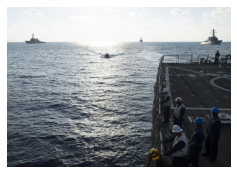

tensor([  101,  1037,  4796,  2003,  2379,  7167,  1998,  7167,  1997, 17434,
         2008,  2003,  2035, 15131,  2362,  1999,  2367, 12906,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
['COCO']


In [94]:
import numpy as np

sample_ID = 581
img, text, text_mask, labels = testset[sample_ID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
print(text)
print([testset.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])


## 2. Train on the image data

### 2.1 Define a model

In [7]:
class ImgClassifier(torch.nn.Module):
    def __init__(self):
        super(ImgClassifier, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 36, kernel_size = (3, 3))
        self.bn1 = torch.nn.BatchNorm2d(num_features = 36)

        self.conv2 = torch.nn.Conv2d(in_channels = 36, out_channels = 128, kernel_size = (3, 3))
        self.bn2 = torch.nn.BatchNorm2d(num_features = 128)

        self.conv3 = torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3))
        self.bn3 = torch.nn.BatchNorm2d(num_features = 128)

        self.linear1 = torch.nn.Linear(in_features = 128 * 26 * 26, out_features = 128)
        self.bn4 = torch.nn.BatchNorm1d(num_features = 128)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear2 = torch.nn.Linear(in_features = 128, out_features = 2)

    def forward(self, x):
        # First conv layer + maxpool2d + relu.
        x = self.conv1(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        # print(x.shape)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        # print(x.shape)

        # Third conv layer + maxpool2d + relu.
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        # print(x.shape)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        x = x.view(x.size(0), -1)
        # print(x.shape)

        # Pass through linear layers.
        x = self.dropout(x)
        # print(x.shape)
        x = self.linear1(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)

        return x

### 2.2 Train the model

Define datasets and dataloaders

In [21]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = Dataset(split = 'train', image_transform = image_transform)
testset = Dataset(split = 'test', image_transform = image_transform)
valset = Dataset(split = 'val', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = True)

Loadin json file
 finished
Tokenizing... finished
Loadin json file
 finished
Tokenizing... finished
Loadin json file
 finished
Tokenizing... finished


In [99]:
_, (imgs, texts, text_masks, labels) = next(enumerate(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 50]) torch.Size([10, 50]) torch.Size([10, 2])


In [23]:
!pip install livelossplot --quiet
!pip -q install transformers

In [107]:
def count_correct(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    true_sorted_vals, true_sorted_ids = \
        labels.sort(dim = 1, descending = True)
    pred_vals = sorted_ids[:, 0]
    true_vals = true_sorted_ids[:, 0]
    return (pred_vals == true_vals).sum()

In [141]:
# Your code goes here.
from livelossplot import PlotLosses
import torch.nn as nn

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader,
                ifImg):
    best_accuracy = 0
    liveloss = PlotLosses()
    current_step = 0
    model.cuda()
    for epoch in range(0, n_epochs):
        correct = 0
        cumulative_loss = 0
        num_samples = 0
        logs = {}
        model.train()
        for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
            if ifImg:
                # Move to GPU.
                imgs = imgs.cuda()

                # Compute predictions.
                predicted = model(imgs)
            else:
                # Move to GPU.
                texts = texts.cuda()
                text_masks = text_masks.cuda()

                # Compute predictions.
                predicted = model(texts, text_masks)
                predicted = predicted[0]
            
            labels = labels.cuda()

            # Compute loss.
            loss = cost_function(predicted, labels)

            # Compute cumulative loss and top-5 accuracy.
            cumulative_loss += loss.data.sum().item()
            correct += count_correct(predicted, labels)
            num_samples += imgs.size(0)

            # Backpropagation and SGD update step.
            model.zero_grad()
            loss.mean().backward()
            optimizer.step()

            if batch_id % 100 == 0:
                print('train', epoch, batch_id, correct / num_samples)
                logs['loss'] = cumulative_loss / num_samples
                logs['accuracy'] = correct / num_samples
                liveloss.update(logs)
                liveloss.send()
                current_step += 1
        print('\nEpoch {0} ended with a train-loss of {1:.4f} and training accuracy of {2:.2f}'.
              format(epoch, cumulative_loss /  num_samples, correct /  num_samples))
        
        cumulative_loss = 0
        num_samples = 0
        correct = 0
        model.eval()
        for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):

            if ifImg:
                # Move to GPU.
                imgs = imgs.cuda()

                # Compute predictions.
                predicted = model(imgs)
            else:
                # Move to GPU.
                texts = texts.cuda()
                text_masks = text_masks.cuda()

                # Compute predictions.
                predicted = model(texts, text_masks)
                predicted = predicted[0]
            labels = labels.cuda()
            # Compute loss.
            loss = cost_function(predicted, labels)

            # Compute cumulative loss and top-5 accuracy.
            cumulative_loss += loss.data.sum().item()
            correct += count_correct(predicted, labels)

            num_samples += imgs.size(0)

            if (1 + batch_id) % 100 == 0:
                print('val', epoch, batch_id, correct / num_samples)
                logs['val_loss'] = cumulative_loss / num_samples
                logs['val_accuracy'] = correct / num_samples    
                liveloss.update(logs, current_step)
                liveloss.send()

        # Advance scheduler.
        if scheduler != -1:
            scheduler.step()

        # Save the parameters for the best accuracy on the validation set so far.
        if logs['val_accuracy'] > best_accuracy:
            best_accuracy = logs['val_accuracy']
            if ifImg:
                torch.save(model.state_dict(), 'best_IMG_model_so_far.pth') 
            else:
                torch.save(model.state_dict(), 'best_text_model_so_far.pth') 


Start training

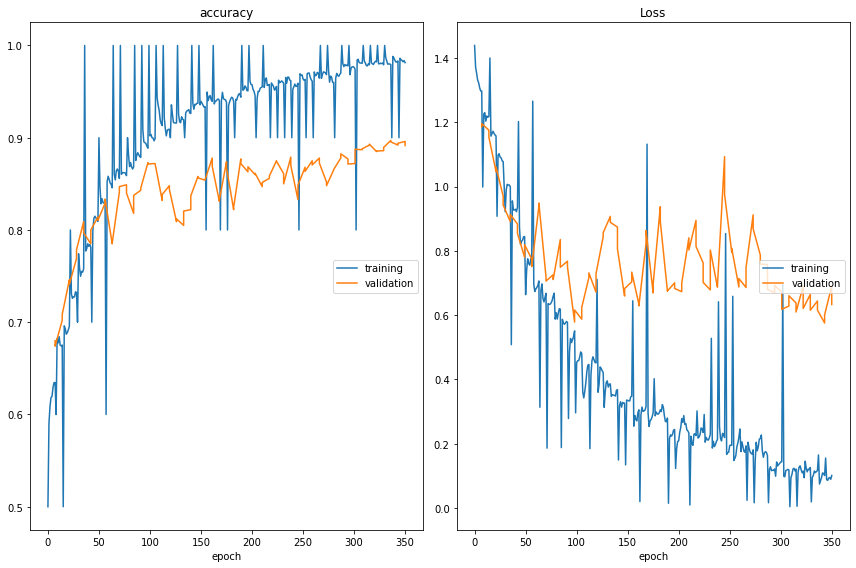

accuracy
	training         	 (min:    0.500, max:    1.000, cur:    0.981)
	validation       	 (min:    0.674, max:    0.897, cur:    0.892)
Loss
	training         	 (min:    0.004, max:    1.439, cur:    0.101)
	validation       	 (min:    0.576, max:    1.196, cur:    0.633)


In [143]:
batch_size = 10
n_epochs = 50
learningRate = 1e-3

# I like to use CrossEntropyLoss so that the classifier doesn't need Softmax.
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')
model = ImgClassifier()

# Same optimizer as before. 
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, scheduler, 
            train_loader, val_loader, True)

## 3. Train on the text data

In [24]:
from transformers import AdamW  # optimizer that comes with this library.
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn

In [125]:
# Loading BERT...
num_categories = len(trainset.categories)
text_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# img, text, text_mask, labels = val_data[22]
# Let's run a quick test on this model on the CPU.
predictions, = text_model(texts, text_masks)
print(predictions)

# Tell pytorch to run this model on the GPU.
model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

logits


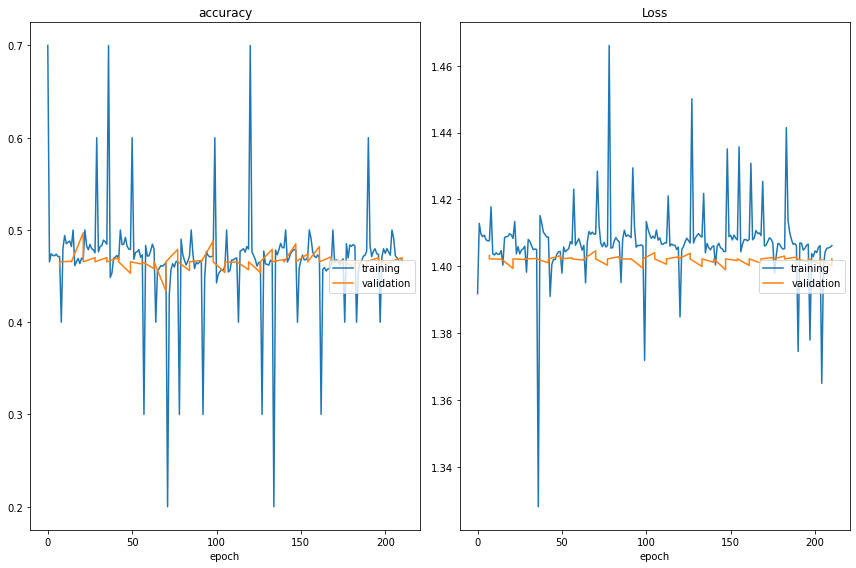

accuracy
	training         	 (min:    0.200, max:    0.700, cur:    0.467)
	validation       	 (min:    0.434, max:    0.497, cur:    0.466)
Loss
	training         	 (min:    1.328, max:    1.466, cur:    1.406)
	validation       	 (min:    1.399, max:    1.405, cur:    1.402)


In [146]:
batch_size = 10
n_epochs = 30
learningRate = 1e-3

optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * n_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Use the training function as above for the image data
train_model(batch_size, n_epochs, learningRate, 
            text_model, cost_function, optimizer, scheduler, 
            train_loader, val_loader, False)

## 4. Sanity Check and Analysis






Threshold for evaluating bias.

In [40]:
def threshold(testset):
  IA = 0
  COCO = 0
  for key in testset.manifest:
    if testset.manifest[key] == 0:
      IA += 1
    else:
      COCO += 1
  value = IA
  if COCO > IA: value = COCO
  print('Number of samples from IAPR TC-12: ', IA)
  print('Number of samples from COCO: ', COCO)
  print('If the accuracy is higher than {0:2f}, it can prove shows there are bias in the datasets.'.format(value/(IA + COCO)))
  return IA + COCO

### 4.1 For image

We can see a pretty high accuracy when training and validation. But is it the case also for the testset? We can check it here.

In [56]:
final_model = ImgClassifier()
final_model.load_state_dict(torch.load('/content/best_IMG_model_so_far.pth'))
# final_model.load_state_dict(torch.load('/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set/best_IMG_model_so_far.pth'))
final_model.cuda()

ImgClassifier(
  (conv1): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(36, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=86528, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=128, out_features=2, bias=True)
)

In [57]:
print('This dataset has {0} training images'.format(len(trainset)))

This dataset has 7000 training images


In [61]:
import random

def examples(model, testset, num = 5):
  model.eval()

  for i in range(num):
    image_index = random.randint(0, len(testset)) 
    img, text, text_mask, label = testset[image_index] 
    plt.figure()
    plt.imshow(img.transpose(0,2).transpose(0,1));
    plt.grid(False); plt.axis('off')
    plt.show()
    img = img.cuda()
    print(torch.sigmoid(model(img[None])))
    true_label = torch.max(label[None], 1)[1]
    predicted = torch.max(torch.sigmoid(model(img[None])), 1)[1]
    print('Image {0} is a {1}'.format(image_index, valset.categories[true_label]))
    print('The prediction is {0}'.format(valset.categories[predicted]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


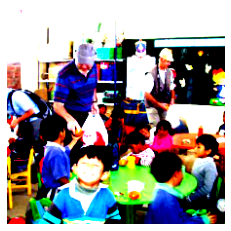

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[9.9992e-01, 7.5020e-05]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 382 is a IAPR TC-12
The prediction is IAPR TC-12


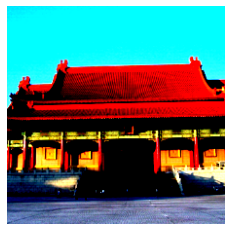

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[9.9949e-01, 5.0556e-04]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 974 is a IAPR TC-12
The prediction is IAPR TC-12


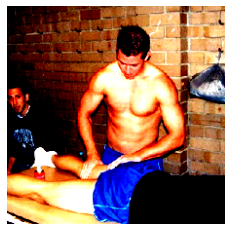

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.8663, 0.1347]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 0 is a IAPR TC-12
The prediction is IAPR TC-12


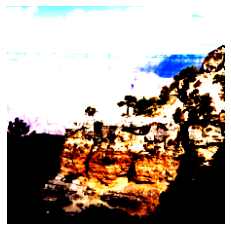

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.9912, 0.0088]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 730 is a IAPR TC-12
The prediction is IAPR TC-12


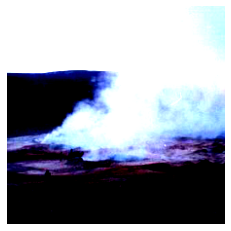

tensor([[0.9819, 0.0182]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 973 is a IAPR TC-12
The prediction is IAPR TC-12


In [62]:
examples(final_model, valset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


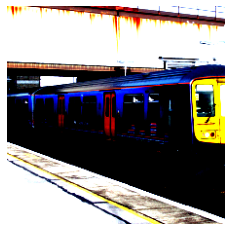

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1.0271e-17, 1.0000e+00]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 883 is a COCO
The prediction is COCO


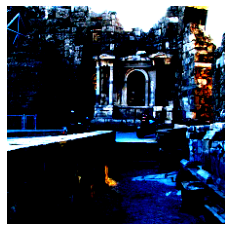

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[7.4991e-04, 9.9925e-01]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 946 is a COCO
The prediction is COCO


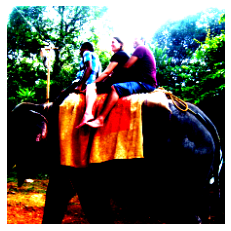

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1.8913e-04, 9.9981e-01]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 764 is a COCO
The prediction is COCO


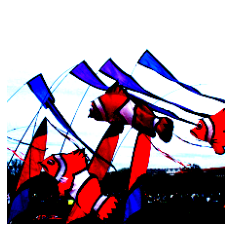

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[2.6426e-11, 1.0000e+00]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 775 is a COCO
The prediction is COCO


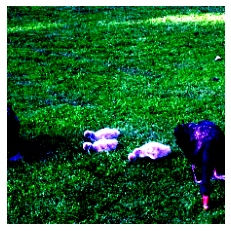

tensor([[0.3690, 0.6322]], device='cuda:0', grad_fn=<SigmoidBackward>)
Image 103 is a IAPR TC-12
The prediction is COCO


In [63]:
examples(final_model, testset)

In [158]:
print('For validation set:')
val_total = threshold(valset)
print('For test set:')
test_total = threshold(testset)

For validation set:
Number of samples from IAPR TC-12:  1000
Number of samples from COCO:  1000
If the accuracy is higher than 0.500000, it can prove shows there are bias in the datasets.
For test set:
Number of samples from IAPR TC-12:  500
Number of samples from COCO:  500
If the accuracy is higher than 0.500000, it can prove shows there are bias in the datasets.


In [92]:
def cal_acc(final_model, testset):
  coco_true = 0
  coco_false = 0
  IA_true = 0
  IA_false = 0
  correct = 0
  for index in range(len(testset)):
    img, text, text_mask, label  = testset[index]  # Returns image and label. 
    img = img.cuda()
    true_label = torch.max(label[None], 1)[1]
    predicted = torch.max(torch.sigmoid(final_model(img[None])), 1)[1]
    true_category = testset.categories[true_label]
    predicted_category = testset.categories[predicted]
    if true_category == predicted_category:
      correct += 1
      if predicted_category == 'COCO':
        coco_true += 1
      else:
        IA_true += 1
    else:
      if predicted_category == 'IAPR TC-12':
        IA_false += 1
      else:
        coco_false += 1
  return correct/len(testset), coco_true, coco_false, IA_true, IA_false


In [93]:
val_acc, val_coco_true, val_coco_false, val_IA_true, val_IA_false = cal_acc(final_model, valset)
print('Accuracy on the validation set is: ', val_acc)
test_acc, test_coco_true, test_coco_false, test_IA_true, test_IA_false = cal_acc(final_model, testset)
print('Accuracy on the test set is: ', test_acc)

Accuracy on the validation set is:  0.8925
Accuracy on the test set is:  0.911


In [94]:
print('For the validation set:')
print('Out of all the samples predicted as COCO,{0} are true, {1} are actually IAPR-TC-12'.format(val_coco_true, val_coco_false))
print('Out of all the samples predicted as IA,{0} are true, {1} are actually IAPR-TC-12'.format(val_IA_true, val_IA_false))
print('For the test set:')
print('Out of all the samples predicted as COCO,{0} are true, {1} are actually IAPR-TC-12'.format(test_coco_true, test_coco_false))
print('Out of all the samples predicted as IA,{0} are true, {1} are actually IAPR-TC-12'.format(test_IA_true, test_IA_false))

For the validation set:
Out of all the samples predicted as COCO,904 are true, 119 are actually IAPR-TC-12
Out of all the samples predicted as IA,881 are true, 96 are actually IAPR-TC-12
For the test set:
Out of all the samples predicted as COCO,460 are true, 49 are actually IAPR-TC-12
Out of all the samples predicted as IA,451 are true, 40 are actually IAPR-TC-12


### 4.2 For texts

In [27]:
final_model_text = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = 2,  output_attentions = False, 
    output_hidden_states = False)
final_model_text.load_state_dict(torch.load('/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set/best_text_model_so_far.pth'))
final_model_text.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [28]:
print('This dataset has {0} training images'.format(len(trainset)))

This dataset has 7000 training images


In [37]:
import random

def examples(model, testset, num = 5):
  model.eval()

  for i in range(num):
    image_index = random.randint(0, len(testset)) 
    img, text, text_mask, label = testset[image_index]
    text = text.cuda()
    text_mask = text_mask.cuda()
    print(testset.tokenizer.decode(text))
    print(torch.sigmoid(model(text[None], text_mask[None])[0]))
    true_label = torch.max(label[None], 1)[1]
    predicted = torch.max(torch.sigmoid(model(text[None], text_mask[None])[0]), 1)[1]
    print('Text {0} is a {1}'.format(image_index, valset.categories[true_label]))
    print('The prediction is {0}'.format(valset.categories[predicted]))

In [38]:
examples(final_model_text, valset)

[CLS] a person holding a multicolored umbrella looking at a body of water. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
tensor([[0.5553, 0.5186]], device='cuda:0', grad_fn=<SigmoidBackward>)
Text 1178 is a COCO
The prediction is IAPR TC-12
[CLS] pink flamingos are standing in a shallow salt lagoon in front of a high, brown, bald mountain [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
tensor([[0.5363, 0.4754]], device='cuda:0', grad_fn=<SigmoidBackward>)
Text 612 is a IAPR TC-12
The prediction is IAPR TC-12
[CLS] a young boy wearing his baseball uniform with his bat in his hands [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [39]:
examples(final_model_text, testset)

[CLS] a large, grey building with two small towers and a high black dome [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
tensor([[0.5547, 0.5511]], device='cuda:0', grad_fn=<SigmoidBackward>)
Text 410 is a IAPR TC-12
The prediction is IAPR TC-12
[CLS] a woman is standing in front of a blue and yellow train in the middle of a light brown desert landscape [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
tensor([[0.5366, 0.5016]], device='cuda:0', grad_fn=<SigmoidBackward>)
Text 171 is a IAPR TC-12
The prediction is IAPR TC-12
[CLS] a man with a black jacket is standing in a flat, white desert with a blue sky in the background [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [41]:
print('For validation set:')
val_total = threshold(valset)
print('For test set:')
test_total = threshold(testset)

For validation set:
Number of samples from IAPR TC-12:  1000
Number of samples from COCO:  1000
If the accuracy is higher than 0.500000, it can prove shows there are bias in the datasets.
For test set:
Number of samples from IAPR TC-12:  500
Number of samples from COCO:  500
If the accuracy is higher than 0.500000, it can prove shows there are bias in the datasets.


Accuracy on valset and testset

In [89]:
def cal_acc(final_model, testset):
  coco_true = 0
  coco_false = 0
  IA_true = 0
  IA_false = 0
  correct = 0
  for index in range(len(testset)):
    img, text, text_mask, label = testset[index]
    text = text.cuda()
    text_mask = text_mask.cuda()
    true_label = torch.max(label[None], 1)[1]
    predicted = torch.max(torch.sigmoid(final_model(text[None], text_mask[None])[0]), 1)[1]
    true_category = testset.categories[true_label]
    predicted_category = testset.categories[predicted]
    if true_category == predicted_category:
      correct += 1
      if predicted_category == 'COCO':
        coco_true += 1
      else:
        IA_true += 1
    else:
      if predicted_category == 'IAPR TC-12':
        IA_false += 1
      else:
        coco_false += 1
  return correct/len(testset), coco_true, coco_false, IA_true, IA_false

In [90]:
val_acc, val_coco_true, val_coco_false, val_IA_true, val_IA_false = cal_acc(final_model_text, valset)
print('Accuracy on the validation set is: ', val_acc)
test_acc, test_coco_true, test_coco_false, test_IA_true, test_IA_false = cal_acc(final_model_text, testset)
print('Accuracy on the test set is: ', test_acc)

Accuracy on the validation set is:  0.4655
Accuracy on the test set is:  0.478


In [91]:
print('For the validation set:')
print('Out of all the samples predicted as COCO,{0} are true, {1} are actually IAPR-TC-12'.format(val_coco_true, val_coco_false))
print('Out of all the samples predicted as IA,{0} are true, {1} are actually IAPR-TC-12'.format(val_IA_true, val_IA_false))
print('For the test set:')
print('Out of all the samples predicted as COCO,{0} are true, {1} are actually IAPR-TC-12'.format(test_coco_true, test_coco_false))
print('Out of all the samples predicted as IA,{0} are true, {1} are actually IAPR-TC-12'.format(test_IA_true, test_IA_false))

For the validation set:
Out of all the samples predicted as COCO,36 are true, 105 are actually IAPR-TC-12
Out of all the samples predicted as IA,895 are true, 964 are actually IAPR-TC-12
For the test set:
Out of all the samples predicted as COCO,17 are true, 39 are actually IAPR-TC-12
Out of all the samples predicted as IA,461 are true, 483 are actually IAPR-TC-12


## Misc.

In [145]:
!cp -r '/content/train' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/test' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/val' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/test.txt' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/train.txt' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/val.txt' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/train_texts.txt' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/test_texts.txt' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/val_texts.txt' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/texts_dict.txt' '//content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/best_IMG_model_so_far.pth' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
!cp -r '/content/best_text_model_so_far.pth' '/content/drive/MyDrive/2020Fall Vision & Language/Project/final_set'
